<a href="https://colab.research.google.com/github/BAEK-SEUNGYUN/modu_deep/blob/main/nlp_%EA%B8%80%EC%9E%90%EB%8B%A8%EC%9C%84%EB%A1%9C_%ED%85%8D%EC%8A%A4%ED%8A%B8_%EC%83%9D%EC%84%B1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# '경마장에 말이 달리고 있다.'
# 경마장에
# 말이
# 달리고
# 있다.
#단어단위


# 글자단위
# 경
# 마
# 장
# 에
# 말
# 이
# 달
# 리
# 고
# 있
# 다


## 글자 단위 RNN 언어 모델

![r](https://wikidocs.net/images/page/48649/char_rnn1.PNG)

In [3]:
import numpy as np
import urllib.request
from tensorflow.keras.utils import to_categorical

In [4]:
urllib.request.urlretrieve("http://www.gutenberg.org/files/11/11-0.txt", filename="11-0.txt")


('11-0.txt', <http.client.HTTPMessage at 0x7f3dcb0f87d0>)

In [5]:
f = open('11-0.txt', 'rb')
lines = []
for line in f:
  line = line.strip()   # strip을 통해 \r, \n 제거
  line = line.lower()   # 소문자화
  line = line.decode('ascii','ignore')    # \we2\x80\x99등과 같은 바이트 열 제거
  if len(line) > 0:
    lines.append(line)

f.close()

In [6]:
lines[:5]

['the project gutenberg ebook of alices adventures in wonderland, by lewis carroll',
 'this ebook is for the use of anyone anywhere in the united states and',
 'most other parts of the world at no cost and with almost no restrictions',
 'whatsoever. you may copy it, give it away or re-use it under the terms',
 'of the project gutenberg license included with this ebook or online at']

In [7]:
# 하나의 문자열로 통합
text = ' '.join(lines)
print('문자열의 길이 또는 총 글자의 갯수 : %d' %len(text))

문자열의 길이 또는 총 글자의 갯수 : 159484


In [8]:
print(text[:100])

the project gutenberg ebook of alices adventures in wonderland, by lewis carroll this ebook is for t


In [9]:
# 글자 집합을 만들어보자
char_vocab = sorted(list(set(text)))
vocab_size = len(char_vocab)
print('글자 집합의 크기 : {}'.format(vocab_size))

글자 집합의 크기 : 56


In [10]:
print(char_vocab)

[' ', '!', '"', '#', '$', '%', "'", '(', ')', '*', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '?', '[', ']', '_', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


In [11]:
# 글자 집합에 인덱스를 부여하고 전부 출력하기
char_to_index = dict((c,i) for i,c in enumerate(char_vocab))
print(char_to_index)

{' ': 0, '!': 1, '"': 2, '#': 3, '$': 4, '%': 5, "'": 6, '(': 7, ')': 8, '*': 9, ',': 10, '-': 11, '.': 12, '/': 13, '0': 14, '1': 15, '2': 16, '3': 17, '4': 18, '5': 19, '6': 20, '7': 21, '8': 22, '9': 23, ':': 24, ';': 25, '?': 26, '[': 27, ']': 28, '_': 29, 'a': 30, 'b': 31, 'c': 32, 'd': 33, 'e': 34, 'f': 35, 'g': 36, 'h': 37, 'i': 38, 'j': 39, 'k': 40, 'l': 41, 'm': 42, 'n': 43, 'o': 44, 'p': 45, 'q': 46, 'r': 47, 's': 48, 't': 49, 'u': 50, 'v': 51, 'w': 52, 'x': 53, 'y': 54, 'z': 55}


In [12]:
# 인덱스로부터 글자를 리턴하기
index_to_char = {}
for key, value in char_to_index.items():
  index_to_char[value] = key

In [13]:
  print(index_to_char)

{0: ' ', 1: '!', 2: '"', 3: '#', 4: '$', 5: '%', 6: "'", 7: '(', 8: ')', 9: '*', 10: ',', 11: '-', 12: '.', 13: '/', 14: '0', 15: '1', 16: '2', 17: '3', 18: '4', 19: '5', 20: '6', 21: '7', 22: '8', 23: '9', 24: ':', 25: ';', 26: '?', 27: '[', 28: ']', 29: '_', 30: 'a', 31: 'b', 32: 'c', 33: 'd', 34: 'e', 35: 'f', 36: 'g', 37: 'h', 38: 'i', 39: 'j', 40: 'k', 41: 'l', 42: 'm', 43: 'n', 44: 'o', 45: 'p', 46: 'q', 47: 'r', 48: 's', 49: 't', 50: 'u', 51: 'v', 52: 'w', 53: 'x', 54: 'y', 55: 'z'}


In [14]:
# 훈련데이터를 구성
# apple 
# sample의 길이 4

# example) 샘플의 길이가 4라면 4개의 입력 글자 시퀀스로부터 4개의 출력 글자 시퀀스 예측. 즉 RNN의 time step은 4번
# appl -> pple
# appl (입력시퀀스, train_x), pple(예측해야하는 시퀀스, train_y)

In [15]:
# 15만 8천의 길이를 가진 text문자열로부터 다수의 문장 샘플들로 분리
# 분리하는 방법은 문장 샘플의 길이를 정하고, 해당 길이만큼 문자열 전부를 전부 등분 하는 것!!
seq_length = 60
n_samples = int(np.floor((len(text)-1)/seq_length)) #문자열을 60등분한다 ---> 총 샘플의 수
print('문장 샘플의 수 : {}'.format(n_samples))

문장 샘플의 수 : 2658


In [16]:
train_x = []
train_y = []

for i in range(n_samples): # 2658번 수행
  x_sample = text[i * seq_length: (i+1)*seq_length] # 문장 샘플을 1개씩 가져온다.
  x_encoded = [char_to_index[c] for c in x_sample] # 하나의 문장 샘플에 대해서 정수 인코딩
  train_x.append(x_encoded)

  y_sample = text[i*seq_length + 1: (i+1) *seq_length + 1] # 오른쪽으로 1칸 쉬프트한다.
  y_encoded = [char_to_index[c] for c in y_sample]
  train_y.append(y_encoded)

In [17]:
print(train_x[0])

[49, 37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30]


In [18]:
print(train_y[0])

[37, 34, 0, 45, 47, 44, 39, 34, 32, 49, 0, 36, 50, 49, 34, 43, 31, 34, 47, 36, 0, 34, 31, 44, 44, 40, 0, 44, 35, 0, 30, 41, 38, 32, 34, 48, 0, 30, 33, 51, 34, 43, 49, 50, 47, 34, 48, 0, 38, 43, 0, 52, 44, 43, 33, 34, 47, 41, 30, 43]


In [19]:
print(train_x[1])

[43, 33, 10, 0, 31, 54, 0, 41, 34, 52, 38, 48, 0, 32, 30, 47, 47, 44, 41, 41, 0, 49, 37, 38, 48, 0, 34, 31, 44, 44, 40, 0, 38, 48, 0, 35, 44, 47, 0, 49, 37, 34, 0, 50, 48, 34, 0, 44, 35, 0, 30, 43, 54, 44, 43, 34, 0, 30, 43, 54]


In [20]:
print(train_y[1])

[33, 10, 0, 31, 54, 0, 41, 34, 52, 38, 48, 0, 32, 30, 47, 47, 44, 41, 41, 0, 49, 37, 38, 48, 0, 34, 31, 44, 44, 40, 0, 38, 48, 0, 35, 44, 47, 0, 49, 37, 34, 0, 50, 48, 34, 0, 44, 35, 0, 30, 43, 54, 44, 43, 34, 0, 30, 43, 54, 52]


In [21]:
# x 와 y 에 대해 원-핫 이코딩 수행, 입력 시퀀스에 대해 워드 임베딩 하지 않습니다. -> embedding layer 사용 X
train_x = to_categorical(train_x)
train_y = to_categorical(train_y)

In [22]:
print('train_x의 크기 (shape) : {}'.format(train_x.shape))
print('train_y의 크기 (shape) : {}'.format(train_y.shape))

train_x의 크기 (shape) : (2658, 60, 56)
train_y의 크기 (shape) : (2658, 60, 56)


샘플의 수가 2658, 입력시퀀스의 길이(input_length) 60, 각 벡터의 차원(input_dim) 56 의미  
원-핫 벡터의 차원은 글자 집합의 크기인 56

![](https://wikidocs.net/images/page/22886/rnn_image6between7.PNG)

### 모델 설계하기

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, TimeDistributed

In [24]:
model = Sequential()
model.add(LSTM(256, input_shape=(None, train_x.shape[2]), return_sequences=True))
model.add(LSTM(256, return_sequences=True))
model.add(TimeDistributed(Dense(vocab_size, activation='softmax')))

In [25]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics = ['accuracy'])
model.fit(train_x, train_y, epochs=80, verbose=1)

Epoch 1/80
84/84 [==============================] - 10s 13ms/step - loss: 3.0714 - accuracy: 0.1818
Epoch 2/80
84/84 [==============================] - 1s 12ms/step - loss: 2.7553 - accuracy: 0.2389
Epoch 3/80
84/84 [==============================] - 1s 13ms/step - loss: 2.3904 - accuracy: 0.3276
Epoch 4/80
84/84 [==============================] - 1s 12ms/step - loss: 2.2461 - accuracy: 0.3601
Epoch 5/80
84/84 [==============================] - 1s 11ms/step - loss: 2.1374 - accuracy: 0.3883
Epoch 6/80
84/84 [==============================] - 1s 12ms/step - loss: 2.0543 - accuracy: 0.4097
Epoch 7/80
84/84 [==============================] - 1s 12ms/step - loss: 1.9813 - accuracy: 0.4292
Epoch 8/80
84/84 [==============================] - 1s 12ms/step - loss: 1.9207 - accuracy: 0.4457
Epoch 9/80
84/84 [==============================] - 1s 12ms/step - loss: 1.8636 - accuracy: 0.4612
Epoch 10/80
84/84 [==============================] - 1s 12ms/step - loss: 1.8148 - accuracy: 0.4751
Epoch 11

In [26]:
def sentence_generation(model, length):
    ix = [np.random.randint(vocab_size)] # 글자에 대한 랜덤 인덱스 생성
    y_char = [index_to_char[ix[-1]]] # 랜덤 익덱스로부터 글자 생성
    print(ix[-1],'번 글자',y_char[-1],'로 예측을 시작!')
    X = np.zeros((1, length, vocab_size)) # (1, length, 55) 크기의 X 생성. 즉, LSTM의 입력 시퀀스 생성

    for i in range(length):
        X[0][i][ix[-1]] = 1 # X[0][i][예측한 글자의 인덱스] = 1, 즉, 예측 글자를 다음 입력 시퀀스에 추가
        print(index_to_char[ix[-1]], end="")
        ix = np.argmax(model.predict(X[:, :i+1, :])[0], 1)
        y_char.append(index_to_char[ix[-1]])
    return ('').join(y_char)

In [27]:
sentence_generation(model, 100)

50 번 글자 u 로 예측을 시작!
ut for a minute or two sobs choked his voice. same as if he here the foundatly before she falled in 

'ut for a minute or two sobs choked his voice. same as if he here the foundatly before she falled in a'

In [28]:
sentence_generation(model, 30)

48 번 글자 s 로 예측을 시작!
s and writing-desks, which was

's and writing-desks, which wasn'

In [29]:
sentence_generation(model, 100)

42 번 글자 m 로 예측을 시작!
maller, i can creep under the door, and forth intheres, but al crowd of little girds of the back. wh

'maller, i can creep under the door, and forth intheres, but al crowd of little girds of the back. whe'

In [30]:
sentence_generation(model, 25)

35 번 글자 f 로 예측을 시작!
f the month, and doing wh

'f the month, and doing whi'

## 글자 단위 RNN(Char RNN)으로 텍스트 생성하기

다 대 일(many to one)구조의 RNN을 글자 단위로 학습시키고, 텍스트 생성하기

### 데이터에 대한 이해와 전처리

In [31]:
import numpy as np
from tensorflow.keras.utils import to_categorical

In [32]:
text='''
I get on with life as a programmer,
I like to contemplate beer.
But when I start to daydream,
My mind turns straight to wine.

Do I love wine more than beer?

I like to use words about beer.
But when I stop my talking,
My mind turns straight to wine.

I hate bugs and errors.
But I just think back to wine,
And I'm happy once again.

I like to hang out with programming and deep learning.
But when left alone,
My mind turns straight to wine.
'''



In [33]:
tokens = text.split() # '\n 제거'
text = ' '.join(tokens)
print(text)

I get on with life as a programmer, I like to contemplate beer. But when I start to daydream, My mind turns straight to wine. Do I love wine more than beer? I like to use words about beer. But when I stop my talking, My mind turns straight to wine. I hate bugs and errors. But I just think back to wine, And I'm happy once again. I like to hang out with programming and deep learning. But when left alone, My mind turns straight to wine.


In [34]:
char_vocab = sorted(list(set(text))) # 중복을 제한 글자 집합 생성
print(char_vocab)

[' ', "'", ',', '.', '?', 'A', 'B', 'D', 'I', 'M', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'y']


In [35]:
vocab_size = len(char_vocab)
print(f'글자 집합의 크기 : {vocab_size}')

글자 집합의 크기 : 33


In [36]:
char_to_index = dict((c, i) for i,c in enumerate(char_vocab))   # 글자에 고유한 정수 인덱스 부여
print(char_to_index)

{' ': 0, "'": 1, ',': 2, '.': 3, '?': 4, 'A': 5, 'B': 6, 'D': 7, 'I': 8, 'M': 9, 'a': 10, 'b': 11, 'c': 12, 'd': 13, 'e': 14, 'f': 15, 'g': 16, 'h': 17, 'i': 18, 'j': 19, 'k': 20, 'l': 21, 'm': 22, 'n': 23, 'o': 24, 'p': 25, 'r': 26, 's': 27, 't': 28, 'u': 29, 'v': 30, 'w': 31, 'y': 32}


# example 5개의 입력 글자 시퀀스로부터 다음 글자 시퀀스를 예측

- stude -> n

- tuden -> t

In [37]:
length = 11
sequences = []
for i in range(length, len(text)):
  seq = text[i-length:i]  # 길이 11의 문자열을 지속적으로 만듬
  sequences.append(seq)

print('총 훈련 샘플의 수 : %d' %len(sequences))

총 훈련 샘플의 수 : 426


In [38]:
print(sequences)

['I get on wi', ' get on wit', 'get on with', 'et on with ', 't on with l', ' on with li', 'on with lif', 'n with life', ' with life ', 'with life a', 'ith life as', 'th life as ', 'h life as a', ' life as a ', 'life as a p', 'ife as a pr', 'fe as a pro', 'e as a prog', ' as a progr', 'as a progra', 's a program', ' a programm', 'a programme', ' programmer', 'programmer,', 'rogrammer, ', 'ogrammer, I', 'grammer, I ', 'rammer, I l', 'ammer, I li', 'mmer, I lik', 'mer, I like', 'er, I like ', 'r, I like t', ', I like to', ' I like to ', 'I like to c', ' like to co', 'like to con', 'ike to cont', 'ke to conte', 'e to contem', ' to contemp', 'to contempl', 'o contempla', ' contemplat', 'contemplate', 'ontemplate ', 'ntemplate b', 'template be', 'emplate bee', 'mplate beer', 'plate beer.', 'late beer. ', 'ate beer. B', 'te beer. Bu', 'e beer. But', ' beer. But ', 'beer. But w', 'eer. But wh', 'er. But whe', 'r. But when', '. But when ', ' But when I', 'But when I ', 'ut when I s', 't when I

In [39]:
x = []
for line in sequences:   # 전체 데이터에서 문장 샘플을 1개씩 꺼냄
  temp_x = [char_to_index[char] for char in line]  # 문장 샘플에서 각 글자에 대해서 정수 인코딩 수행
  x.append(temp_x)

In [40]:
for line in x[:5]:
  print(line)

[8, 0, 16, 14, 28, 0, 24, 23, 0, 31, 18]
[0, 16, 14, 28, 0, 24, 23, 0, 31, 18, 28]
[16, 14, 28, 0, 24, 23, 0, 31, 18, 28, 17]
[14, 28, 0, 24, 23, 0, 31, 18, 28, 17, 0]
[28, 0, 24, 23, 0, 31, 18, 28, 17, 0, 21]


In [41]:
sequences = np.array(x)
x = sequences[:,:-1]
y = sequences[:,-1] # 맨 마지막 위치의 글자를 분리

In [42]:
for line in x[:5]:
  print(line)

[ 8  0 16 14 28  0 24 23  0 31]
[ 0 16 14 28  0 24 23  0 31 18]
[16 14 28  0 24 23  0 31 18 28]
[14 28  0 24 23  0 31 18 28 17]
[28  0 24 23  0 31 18 28 17  0]


In [43]:
print(y[:5])

[18 28 17  0 21]


### 원-핫 인코딩 수행

In [44]:
sequences = [to_categorical(x, num_classes=vocab_size) for x in x]

In [45]:
x = np.array(sequences)
y = to_categorical(y,num_classes=vocab_size)  # y 에대한 원-핫 인코딩

In [46]:
print(x.shape)

(426, 10, 33)


- 샘플의 수 426  
- 입력시퀀스의 길이 10  
- 각 벡터의 차원 33  

### 모델 설계

In [47]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [48]:
model = Sequential()
model.add(LSTM(128, input_shape=(x.shape[1], x.shape[2])))
model.add(Dense(vocab_size, activation='softmax'))

In [49]:
model.compile(loss='categorical_crossentropy', optimizer= 'adam', metrics=['accuracy'])
model.fit(x, y, epochs=100, verbose=1)

Epoch 1/100
14/14 [==============================] - 2s 4ms/step - loss: 3.4449 - accuracy: 0.1620
Epoch 2/100
14/14 [==============================] - 0s 4ms/step - loss: 3.1919 - accuracy: 0.1972
Epoch 3/100
14/14 [==============================] - 0s 4ms/step - loss: 3.0047 - accuracy: 0.1972
Epoch 4/100
14/14 [==============================] - 0s 4ms/step - loss: 2.9627 - accuracy: 0.1972
Epoch 5/100
14/14 [==============================] - 0s 4ms/step - loss: 2.9322 - accuracy: 0.1972
Epoch 6/100
14/14 [==============================] - 0s 4ms/step - loss: 2.9079 - accuracy: 0.1972
Epoch 7/100
14/14 [==============================] - 0s 4ms/step - loss: 2.8845 - accuracy: 0.1972
Epoch 8/100
14/14 [==============================] - 0s 5ms/step - loss: 2.8583 - accuracy: 0.1972
Epoch 9/100
14/14 [==============================] - 0s 4ms/step - loss: 2.8145 - accuracy: 0.2066
Epoch 10/100
14/14 [==============================] - 0s 5ms/step - loss: 2.7709 - accuracy: 0.1995
Epoch 11/

In [50]:
def sentence_generation(model, char_to_index, seq_length, seed_text, n):
  # 모델, 인덱스 정보, 문장 길이, 초기 시퀀스, 반복 횟수

  init_text = seed_text #문장 생성에 사용할 초기 시퀀스
  sentence = ''

  for _ in range(n): # n번 반복
    encoded = [char_to_index[char] for char in seed_text] #현재 시퀀스에 대한 정수 인코딩
    encoded = pad_sequences([encoded], maxlen=seq_length, padding='pre') #데이터에 대한 패딩
    encoded = to_categorical(encoded, num_classes=len(char_to_index))
    result = model.predict_classes(encoded, verbose=0)
    #입력한 x(현재 시퀀스)에 대해서 y를 예측하고 y(예측한 글자)를 result에 저장

    for char, index in char_to_index.items(): #만약 예측한 글자와 인덱스와 동일한 글자가 있다면
      if index == result: #해당 글자가 예측 글자이므로 break
        break
    
    seed_text = seed_text + char # 현재 시퀀스 + 예측 글자를 현재 시퀀스에 변경
    sentence = sentence + char # 예측 글자를 문장에 저장

  sentence = init_text + sentence
  return sentence

In [51]:
print(sentence_generation(model, char_to_index, 10, 'I get on w', 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


I get on with life as a programmer, I like to use words about beer. But when I start to daydream, My mind turn


In [52]:
print(sentence_generation(model, char_to_index, 10, 'Do I love wine', 100))

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Do I love wine more than beer? I like to use words about beer. But when I start to daydream, My mind turns straigh


## 네이버 쇼핑 리뷰 감성 분석
- 총 200,000ro 리뷰로 구성  
- 평점이 5점 만점에 1, 2, 4, 5인 리뷰들로 구성
- 평점이 4, 5인 리뷰들에 긍정 1, 부정 0
- 감성 분류 수행

In [53]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
# mecab

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 91, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (85/85), done.
remote: Total 91 (delta 43), reused 22 (delta 6), pack-reused 0
Unpacking objects: 100% (91/91), done.


In [54]:
!pwd 

/content


In [55]:
cd Mecab-ko-for-Google-Colab

/content/Mecab-ko-for-Google-Colab


In [56]:
ls

images/                                    LICENSE
install_mecab-ko_on_colab190912.sh         README.md
install_mecab-ko_on_colab_light_210108.sh


In [57]:
!bash install_mecab-ko_on_colab190912.sh

Installing konlpy.....
     |████████████████████████████████| 19.4MB 60.2MB/s 
     |████████████████████████████████| 450kB 42.1MB/s 
     |████████████████████████████████| 92kB 11.2MB/s 
  Found existing installation: beautifulsoup4 4.6.3
    Uninstalling beautifulsoup4-4.6.3:
      Successfully uninstalled beautifulsoup4-4.6.3
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2021-06-17 13:58:54--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22c2:513, 2406:da00:ff00::22c3:9b0a, ...
Connecting to bitbucket.org (bitbucket.org)|104.192.141.1|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://bbuseruploads.s3.amazonaws.com/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz?Signature=HfIkqA1zctPViu2MDcxZD2Befk8%3D&Expires=1623939561&AWSAccessKeyId=AKIA6KOSE3BN

In [58]:
from konlpy.tag import Mecab

In [59]:
mecab = Mecab() # mecab 테스트중
print(mecab.morphs('오늘 너무 피곤하고 몸도 아프고 제정신이 아니네 ㅠㅠ'))

['오늘', '너무', '피곤', '하', '고', '몸', '도', '아프', '고', '제정신', '이', '아니', '네', 'ㅠㅠ']


In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


### 데이터 로드

In [61]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/bab2min/corpus/master/sentiment/naver_shopping.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7f3d16341f50>)

In [62]:
total_data = pd.read_table('ratings_total.txt', names=['ratings', 'reviews'])

In [63]:
print('전체 리뷰 갯수 :', len(total_data))

전체 리뷰 갯수 : 200000


In [64]:
total_data[:5]

,ratings,reviews
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


### 훈련 데이터와 테스트 데이터를 분리

In [65]:
total_data['label'] = np.select([total_data.ratings > 3], [1], default=0)
total_data[:5]

,ratings,reviews,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1


In [66]:
# 각 열에 중복을 제외한 샘플의 수를 카운트
total_data['ratings'].nunique(), total_data['reviews'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

In [67]:
total_data.drop_duplicates(subset=['reviews'], inplace=True) #reviews열에서 중복인 내용이 있다면 중복 제거
print('총 샘플의 수 : ',len(total_data))

총 샘플의 수 :  199908


In [68]:
# NULL값 유무
print(total_data.isnull().values.any())

False


In [69]:
# 훈련데이터와 테스트 데이터 3:1비율로 나눔
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state=42)
print('훈련용 리뷰의 갯수 : ', len(train_data))
print('테스트용 리뷰의 갯수 : ', len(test_data))

훈련용 리뷰의 갯수 :  149931
테스트용 리뷰의 갯수 :  49977


## 레이블의 분포 확인

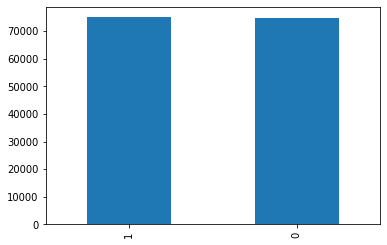

In [70]:
train_data['label'].value_counts().plot(kind='bar')

In [71]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  74918
1      1  75013


## 데이터 정제하기

정규표현식을 사용하여 한글을 제외하고 모두 제거

빈 샘플이 생겼는지 확인

In [72]:
train_data['reviews'] = train_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
train_data['reviews'].replace('', np.nan, inplace=True)
print(train_data.isnull().sum())

ratings    0
reviews    0
label      0
dtype: int64


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  method=method,


In [73]:
test_data.drop_duplicates(subset=['reviews'], inplace=True)
test_data['reviews'] = test_data['reviews'].str.replace("[^ㄱ-ㅎ ㅏ-ㅣ 가-힣]","")
test_data['reviews'].replace('', np.nan, inplace=True)
test_data = test_data.dropna(how='any')
print('전처리 후 테스트용 샘플의 갯수 : ',len(test_data))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:4582: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  

전처리 후 테스트용 샘플의 갯수 :  49977


### 토큰화

In [74]:
mecab = Mecab()
print(mecab.morphs('이런 상품도 상품이라고 허허허'))

['이런', '상품', '도', '상품', '이', '라고', '허허허']


### 불용어 제거

In [75]:
stopwords = ['도', '는', '다', '의', '가', '이', '은', '한', '에', '하', '고', '을', '를', '인', '듯', '과', '와', '네', '들', '듯', '지', '임', '게']

In [76]:
train_data['tokenized'] = train_data['reviews'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [77]:
test_data['tokenized'] = test_data['reviews'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

### 단어와 길이 분포 확인하기


In [78]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)


In [79]:
## 부정리뷰에 대해서 빈도가 높은 상위 20개 단어 출력. Counter()를 사용하여 각 단어에 대한 빈도수 계산
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('네요', 31799), ('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('좋', 9812), ('배송', 9677), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345), ('잘', 8029), ('않', 7984)]


In [80]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('네요', 19895), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


긍정 리뷰의 평균 길이 : 13.587751456414221
부정 리뷰의 평균 길이 : 17.029512266744973


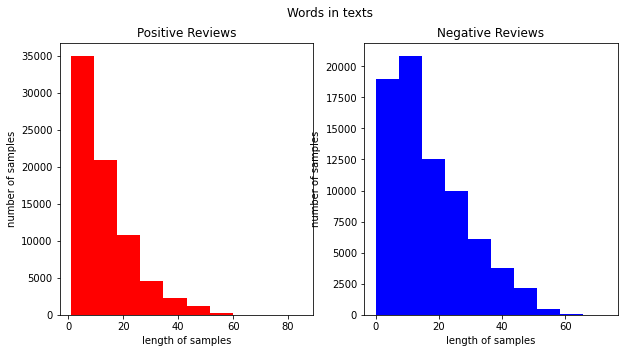

In [81]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
text_len = train_data[train_data['label']== 1]['tokenized'].map(lambda x: len(x))
ax1.hist(text_len, color ='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')
print('긍정 리뷰의 평균 길이 :',np.mean(text_len))

text_len = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))
ax2.hist(text_len, color='blue')
ax2.set_title('Negative Reviews')
fig.suptitle('Words in texts')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')
print('부정 리뷰의 평균 길이 :', np.mean(text_len))
plt.show()

In [82]:
x_train = train_data['tokenized'].values
y_train = train_data['label'].values
x_test = test_data['tokenized'].values
y_test = test_data['label'].values

### 정수 인코딩

In [83]:
t = Tokenizer()
t.fit_on_texts(x_train)

In [84]:
threshold = 2
total_cnt = len(t.word_index) #단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍을 key와 value로 받는다.
for key, value in t.word_counts.items():
  total_freq = total_freq + value

  if (value < threshold):
    rare_cnt = rare_cnt + 1
    rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀단어의 수: %s '% (threshold-1, rare_cnt))
print('단어 집합에서 희귀 단어의 비율 :', (rare_cnt/ total_cnt)*100)
print('전체 등장 빈도에서 희귀단어 등장 빈도 비율: ',(rare_freq/total_freq)*100)

단어 집합(vocabulary)의 크기 : 39998
등장 빈도가 1번 이하인 희귀단어의 수: 18213 
단어 집합에서 희귀 단어의 비율 : 45.53477673883694
전체 등장 빈도에서 희귀단어 등장 빈도 비율:  0.7935688376196857


In [85]:
# 전체 단어 갯수 중 빈도수 2이하인 단어 갯수는 제거
# 0번 패딩 토큰고 1번 OOV토큰을 고려해서 +2
vocab_size = total_cnt - rare_cnt + 2
print('단어 집합의 크기 :', vocab_size)

단어 집합의 크기 : 21787


In [86]:
original_vocab_size = vocab_size + rare_cnt -2
print('원래 vocab size : ', original_vocab_size)

원래 vocab size :  39998


In [87]:
tokenizer = Tokenizer(vocab_size, oov_token='OOV')
tokenizer.fit_on_texts(x_train)
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)

In [88]:
print(x_train[:3])
print(x_test[:3])

[[67, 2060, 299, 14259, 263, 73, 6, 236, 168, 137, 805, 2951, 625, 2, 77, 62, 207, 40, 1343, 155, 3, 6], [482, 409, 52, 8530, 2561, 2517, 339, 2918, 250, 2357, 38, 473, 2], [46, 24, 825, 105, 35, 2372, 160, 7, 10, 8061, 4, 1319, 29, 140, 322, 41, 59, 160, 140, 7, 1916, 2, 113, 162, 1379, 323, 119, 136]]
[[14, 704, 767, 116, 186, 252, 12], [339, 3904, 62, 3816, 1651], [11, 69, 2, 49, 164, 3, 27, 15, 6, 513, 289, 17, 92, 110, 564, 59, 7, 2]]


### 패딩

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.307541469075774


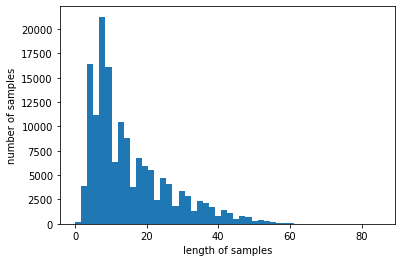

In [89]:
print('리뷰의 최대 길이 :', max(len(l) for l in x_train))
print('리뷰의 평균 길이 :', sum(map(len, x_train))/len(x_train))
plt.hist([len(s) for s in x_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [90]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if (len(s) <= max_len):
      cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율 : %s'%(max_len, (cnt/len(nested_list))*100))

In [91]:
max_len = 80
below_threshold_len(max_len, x_train)

전체 샘플 중 길이가 80 이하인 샘플의 비율 : 99.99933302652553


In [92]:
x_train = pad_sequences(x_train, maxlen= max_len)
x_test = pad_sequences(x_test, maxlen=max_len)

In [93]:
print(x_train.shape)
print(x_test.shape)

(149931, 80)
(49977, 80)


### GRU모델로 학습하기

In [94]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [95]:
model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(GRU(128))
model.add(Dense(1, activation='sigmoid'))

In [96]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [97]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train, epochs= 30, callbacks=[es, mc], batch_size = 60, validation_split=0.2)

Epoch 1/30
2000/2000 [==============================] - 69s 34ms/step - loss: 0.2701 - acc: 0.8974 - val_loss: 0.2241 - val_acc: 0.9181

Epoch 00001: val_acc improved from -inf to 0.91810, saving model to best_model.h5
Epoch 2/30
2000/2000 [==============================] - 68s 34ms/step - loss: 0.1942 - acc: 0.9301 - val_loss: 0.2152 - val_acc: 0.9222

Epoch 00002: val_acc improved from 0.91810 to 0.92217, saving model to best_model.h5
Epoch 3/30
2000/2000 [==============================] - 66s 33ms/step - loss: 0.1597 - acc: 0.9435 - val_loss: 0.2259 - val_acc: 0.9191

Epoch 00003: val_acc did not improve from 0.92217
Epoch 4/30
2000/2000 [==============================] - 65s 32ms/step - loss: 0.1329 - acc: 0.9535 - val_loss: 0.2512 - val_acc: 0.9156

Epoch 00004: val_acc did not improve from 0.92217
Epoch 5/30
2000/2000 [==============================] - 65s 33ms/step - loss: 0.1098 - acc: 0.9615 - val_loss: 0.2717 - val_acc: 0.9120

Epoch 00005: val_acc did not improve from 0.9221

In [98]:
loaded_model = load_model('best_model.h5')
print('\n 테스트 정확도 : %.4f'% (loaded_model.evaluate(x_test, y_test)[1]))

1562/1562 [==============================] - 7s 4ms/step - loss: 0.2202 - acc: 0.9210

 테스트 정확도 : 0.9210


### 리뷰 예측하기

In [99]:
def sentiment_predict(new_sentence):
  new_sentence = mecab.morphs(new_sentence) #토큰화
  new_sentence = [word for word in new_sentence if not word in stopwords] #불용어 제거
  encoded = tokenizer.texts_to_sequences([new_sentence])
  pad_new = pad_sequences(encoded, maxlen=max_len) # 패딩

  score = float(loaded_model.predict(pad_new)) #d예측

  if (score >0.5):
    print('{:.2f}%확률로 긍정 리뷰입니다. '.format(score*100))
  else:
    print('{:.2f}%확률로 부정 리뷰입니다. '.format((1-score)*100))


In [100]:
sentiment_predict('이 상품 진짜 좋아요.. 저는 강추 대박')

96.76%확률로 긍정 리뷰입니다. 


In [101]:
sentiment_predict('이 상품 별로에요..')

99.37%확률로 부정 리뷰입니다. 


In [102]:
sentiment_predict('진짜 배송 늦고 개별로 개짜증')

99.38%확률로 부정 리뷰입니다. 


In [103]:
sentiment_predict('그냥 그래요')

99.41%확률로 부정 리뷰입니다. 


In [104]:
sentiment_predict('ㄴㅇㄹㄴㅇㄹㄴㅇㄹㄴㅇㄹㅇㄴ귀찮아')

71.79%확률로 부정 리뷰입니다. 


In [105]:
sentiment_predict('너무 짱이에요')

99.36%확률로 긍정 리뷰입니다. 


## 글자 단위(Character-level)로 구현한 seq2seq 번역기

In [106]:
!pwd

/content/Mecab-ko-for-Google-Colab


In [107]:
cd ../

/content


In [108]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np

In [109]:
import os
import pandas as pd
file_path = '/content/drive/MyDrive/dataset/fra.txt'
lines = pd.read_csv(file_path, names=['eng', 'fra', 'cc'], sep='\t')
lines.sample(5)

,eng,fra,cc
14465,It looked funny.,Ça avait l'air amusant.,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
66297,You won't be interested.,Vous ne serez pas intéressées.,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
188255,After spending hours out in the cold winter wi...,Après avoir passé des heures au dehors dans le...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
158631,I should've known something was going on.,J'aurais dû savoir qu'il se passait quelque ch...,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
60246,Everyone knows his name.,Tout le monde connaît son nom.,CC-BY 2.0 (France) Attribution: tatoeba.org #1...


In [110]:
lines = lines[['eng', 'fra']][:50000] #5만개 샘플사용
lines.sample(5)

,eng,fra
1546,Well done!,Bravo !
26643,Will you be going?,Irez-vous ?
45630,You're very generous.,Vous êtes très généreuse.
49315,It's the best we have.,C'est le meilleur que nous avons.
28719,I have no religion.,Je n'ai pas de religion.


In [111]:
# 시작토큰과 종료 토큰 추가
sos_token = '\t'
eos_token = '\n'
lines.fra = lines.fra.apply(lambda x: '\t' + x + '\n')
print('전체 샘플의 수 :',len(lines))
lines.sample(5)

전체 샘플의 수 : 50000


,eng,fra
15198,That's old news.,\tOn le sait déjà.\n
34185,How is that spelled?,\tComment l'écrit-on ?\n
6073,We're at war.,\tNous sommes en guerre.\n
33803,He drinks to excess.,\tIl boit trop d'alcool.\n
6900,I can do this.,\tJe peux le faire !\n


In [112]:
eng_tokenizer = Tokenizer(char_level=True)
# 글자 단위로 토큰화
eng_tokenizer.fit_on_texts(lines.eng)
# 50000개의 행을 가진 eng의 각 행에 토큰화 수행
input_text = eng_tokenizer.texts_to_sequences(lines.eng)
# 단어를 숫자값 인덱스로 변환하여 저장
input_text[:3]

[[19, 3, 8], [19, 3, 8], [19, 3, 8]]

In [113]:
fra_tokenizer = Tokenizer(char_level=True)
# 글자 단위로 토큰화
fra_tokenizer.fit_on_texts(lines.fra)
# 50000개의 행을 가진 eng의 각 행에 토큰화 수행
target_text = fra_tokenizer.texts_to_sequences(lines.fra)
# 단어를 숫자값 인덱스로 변환하여 저장
target_text[:3]

[[10, 19, 5, 1, 31, 11],
 [10, 15, 5, 12, 16, 29, 2, 14, 11],
 [10, 26, 9, 8, 28, 2, 1, 31, 11]]

In [114]:
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fra_vocab_size = len(fra_tokenizer.word_index) + 1
print('영어 단어장의 크기 :',eng_vocab_size)
print('프랑스어 단어장의 크기 :', fra_vocab_size)

영어 단어장의 크기 : 52
프랑스어 단어장의 크기 : 73


In [115]:
max_eng_seq_len = max([len(line) for line in input_text])
max_fra_seq_len = max([len(line) for line in target_text])

print('영어 시퀀스의 최대 길이', max_eng_seq_len)
print('프랑스 시퀀스의 최대 길이', max_fra_seq_len)

영어 시퀀스의 최대 길이 22
프랑스 시퀀스의 최대 길이 74


In [116]:
print('전체 샘플의 수 :', len(lines))
print('영어 단어장의 크기:', eng_vocab_size)
print('프랑스어 단어장의 크기:', fra_vocab_size)
print('영어 시퀀스의 최대 길이:', max_eng_seq_len)
print('프랑스 시퀀스의 최대 길이', max_fra_seq_len)

전체 샘플의 수 : 50000
영어 단어장의 크기: 52
프랑스어 단어장의 크기: 73
영어 시퀀스의 최대 길이: 22
프랑스 시퀀스의 최대 길이 74


In [117]:
encoder_input = input_text

# 종료 토큰 제거
decoder_input = [[char for char in line if char != fra_tokenizer.word_index[eos_token]] for line in target_text]
# 시작 토큰 제거
decoder_target = [[char for char in line if char != fra_tokenizer.word_index[sos_token]] for line in target_text]


In [118]:
print(decoder_input[:3]) # <eos>토큰 제거
print(decoder_target[:3]) # <sos>토큰 제거

[[10, 19, 5, 1, 31], [10, 15, 5, 12, 16, 29, 2, 14], [10, 26, 9, 8, 28, 2, 1, 31]]
[[19, 5, 1, 31, 11], [15, 5, 12, 16, 29, 2, 14, 11], [26, 9, 8, 28, 2, 1, 31, 11]]


In [119]:
encoder_input = pad_sequences(encoder_input, maxlen=max_eng_seq_len, padding='post')
decoder_input = pad_sequences(decoder_input, maxlen=max_fra_seq_len, padding='post')
decoder_target = pad_sequences(decoder_target, maxlen=max_fra_seq_len, padding='post')

print('영어 데이터의 크기(shape) :', np.shape(encoder_input))
print('프랑스어 입력데이터의 크기 : ', np.shape(decoder_input))
print('프랑스어 출력데이터의 크기 : ', np.shape(decoder_target))

영어 데이터의 크기(shape) : (50000, 22)
프랑스어 입력데이터의 크기 :  (50000, 74)
프랑스어 출력데이터의 크기 :  (50000, 74)


In [120]:
print(encoder_input[0])

[19  3  8  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]


In [121]:
encoder_input = to_categorical(encoder_input)
decoder_input = to_categorical(decoder_input)
decoder_target = to_categorical(decoder_target)

print('영어 데이터의 크기 :', np.shape(encoder_input))
print('프랑스어 입력데이터의 크기 : ', np.shape(decoder_input))
print('프랑스어 출력데이터의 크기 :', np.shape(decoder_target)) #샘플의 수 x 샘플의 길이 x 단어장의 크기

영어 데이터의 크기 : (50000, 22, 52)
프랑스어 입력데이터의 크기 :  (50000, 74, 73)
프랑스어 출력데이터의 크기 : (50000, 74, 73)


In [122]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('영어 학습데이터의 크기 :', np.shape(encoder_input))
print('프랑스어 학습 입력데이터의 크기 :', np.shape(decoder_input))
print('프랑스어 학습 출력데이터의 크기 :',np.shape(decoder_target))

영어 학습데이터의 크기 : (50000, 22, 52)
프랑스어 학습 입력데이터의 크기 : (50000, 74, 73)
프랑스어 학습 출력데이터의 크기 : (50000, 74, 73)


### 모델 훈련하기

In [123]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [124]:
# LSTM셀의 마지막 time step의 hidden state와 cell state를 디코더 LSTM의 첫번째 hidden state와 cell state전달해주자

encoder_inputs = Input(shape=(None, eng_vocab_size))
# 입력 텐서를 생성
encoder_lstm = LSTM(units= 256, return_state=True)
# hidden state 256인 LSTM을 생성
encoder_outputs, state_h, state_c = encoder_lstm(encoder_inputs)
# 디코더로 전달할 hidden state, cell state를 리턴. encoder_output은 여기서는 불필요.
encoder_states = [state_h, state_c]
# hidden state와 cell state를 다음 time step으로 전달하기 위해서 별도로 저장

In [125]:
decoder_inputs = Input(shape=(None, fra_vocab_size))
# 입력 텐서 생성
decoder_lstm = LSTM(units=256, return_sequences= True, return_state=True)
# hidden state size 256 디코더 LSTM 생성
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state = encoder_states)
# decoder output는 모든 timestep의 hidden state

In [126]:
decoder_softmax_layer = Dense(fra_vocab_size, activation='softmax')
decoder_outputs = decoder_softmax_layer(decoder_outputs)

In [127]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer="rmsprop", loss="categorical_crossentropy")
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, 52)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 256), (None, 316416      input_1[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 lstm_3[0][1]                 

In [128]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), batch_size=128, epochs=30)

Epoch 1/30
368/368 [==============================] - 11s 22ms/step - loss: 0.9054 - val_loss: 0.7946
Epoch 2/30
368/368 [==============================] - 7s 20ms/step - loss: 0.5527 - val_loss: 0.6447
Epoch 3/30
368/368 [==============================] - 7s 20ms/step - loss: 0.4611 - val_loss: 0.5591
Epoch 4/30
368/368 [==============================] - 7s 20ms/step - loss: 0.4059 - val_loss: 0.5145
Epoch 5/30
368/368 [==============================] - 8s 21ms/step - loss: 0.3687 - val_loss: 0.4824
Epoch 6/30
368/368 [==============================] - 8s 21ms/step - loss: 0.3421 - val_loss: 0.4454
Epoch 7/30
368/368 [==============================] - 8s 21ms/step - loss: 0.3218 - val_loss: 0.4265
Epoch 8/30
368/368 [==============================] - 8s 21ms/step - loss: 0.3054 - val_loss: 0.4088
Epoch 9/30
368/368 [==============================] - 8s 21ms/step - loss: 0.2919 - val_loss: 0.4048
Epoch 10/30
368/368 [==============================] - 8s 21ms/step - loss: 0.2804 - val_l

### 모델 테스트

훈련시에 학습해야할 타겟문장을 디코더 모델의 입력, 출력 시퀀스로 넣어주고, 디코더 모델이 타겟문장을 한꺼번에 출력하게 할 수 있습니다. 테스트 단계는 불가능!

테스트 단계에서 디코더 동작 순서
- 인코더에 입력 문장을 넣어 마지막 time step의 hidden, cell state를 얻는다.
- 토큰인 \t를 디코더에 입력한다.
- 이전 timestep의 출력층의 예측결과를 현재 timestep의 입력으로 한다.
- 3을 반복하다가 토큰인 \n가 예측되면 이를 중단한다.


In [129]:
encoder_model = Model(inputs=encoder_inputs, outputs=encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 52)]        0         
_________________________________________________________________
lstm_3 (LSTM)                [(None, 256), (None, 256) 316416    
Total params: 316,416
Trainable params: 316,416
Non-trainable params: 0
_________________________________________________________________


In [130]:
decoder_state_input_h = Input(shape=(256,))
# 이전 timestep의 hidden state를 저장하는 텐서
decoder_state_input_c = Input(shape=(256,))
# 이전 timestep의 cell state를 저장하는 텐서
decoder_state_inputs = [decoder_state_input_h, decoder_state_input_c]
# 이전 time step의 hidden state와 cell state를 하나의 변수에 저장

# decoder_state_inputs를 현재 time step의 초기상태로 사용
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_state_inputs)
# 현재 time step의 hidden state와 cell state를 하나의 변수에 저장
decoder_states = [state_h, state_c]

In [131]:
decoder_outputs = decoder_softmax_layer(decoder_outputs)
decoder_model= Model(inputs=[decoder_inputs] + decoder_state_inputs, outputs=[decoder_outputs]+decoder_states)
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, 73)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 256)]        0                                            
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, None, 256),  337920      input_2[0][0]                    
                                                                 input_3[0][0]              

In [132]:
eng2idx = eng_tokenizer.word_index
fra2idx = fra_tokenizer.word_index
idx2eng = eng_tokenizer.index_word
idx2fra = fra_tokenizer.index_word

In [133]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 상태를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 원-핫 벡터 생성
  target_seq = np.zeros((1, 1, fra_vocab_size))
  target_seq[0, 0, fra2idx['\t']] =1

  stop_condition = False
  decoded_sentence = ""

  # stop condition이 True가 될떄까지 루프 반복
  while not stop_condition:
    # 이전 시점의 상태 state_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq]+ states_value)

    # 예측 결과를 문자로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = idx2fra[sampled_token_index]

    # 현재 시점의 예측 문자를 예측 문장에 추가
    decoded_sentence += sampled_char

    # <eos>에 도달하거나 최대 길이를 넘으면 중단
    if (sampled_char == '\n' or
        len(decoded_sentence) > max_fra_seq_len):
      stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1, 1, fra_vocab_size))
    target_seq[0, 0, sampled_token_index] =1

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]
  return decoded_sentence

In [134]:
import numpy as np
for seq_index in [3, 50, 100, 300, 1001]:
  # 입력 문장의 인덱스 (자유롭게 바꿔서 테스트 해보세요!)
  input_seq = encoder_input[seq_index: seq_index +1]
  decoded_sentence = decode_sequence(input_seq)
  print(35 * "-")
  print('입력 문장 :', lines.eng[seq_index])
  print('정답 문장 :', lines.fra[seq_index][1:len(lines.fra[seq_index])-1])
  # '\t'와 '\n'을 빼고 출력
  print('번역기가 번역한 문장 :', decoded_sentence[:len(decoded_sentence)-1])
  # '\n'을 빼고 출력

-----------------------------------
입력 문장 : Hi.
정답 문장 : Salut !
번역기가 번역한 문장 : salut.
-----------------------------------
입력 문장 : I won!
정답 문장 : Je l'ai emporté !
번역기가 번역한 문장 : je me demande !
-----------------------------------
입력 문장 : I fled.
정답 문장 : J'ai fui.
번역기가 번역한 문장 : j'ai plus chante.
-----------------------------------
입력 문장 : Hug Tom.
정답 문장 : Fais un câlin à Tom.
번역기가 번역한 문장 : dégage !
-----------------------------------
입력 문장 : I give in.
정답 문장 : Je donne ma langue au chat.
번역기가 번역한 문장 : je l'ai dit.
